# Sampling Strategy code development for ligands selection

B) Ligands sampling dataframe:

3) Ligands that have covalent Metal-Ligand connections to specific atoms (e.g. M*-C* bonds) Select highest-propensity ligands from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
4) Ligands that have non-covalent (not first-coordination shell) metal-ligand connections to specific atoms (e.g. M*-N-C* bonds) from across the CSD. (Top N most frequent present - guessing ~20 would be good start)
5) Ensure that ligands selected cover as much known differences in chemistry as possible (e.g. Oxygen vs Water vs. Hydroxyl vs. Oxo ...) - this definition can be a bit Nebulous I'm working on starting with different atom types as a measure of different chemistries.


In [1]:
import pandas as pd
from architector import view_structures,convert_io_molecule
import numpy as np
import matplotlib.pyplot as plt
from architector.io_process_input import assign_ligType_similarity
from tqdm import tqdm

In [2]:
ligdf = pd.read_pickle('reduced_ligand_df.pkl')

In [3]:
ligdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency
0,"O=C([O-])CN1CCCN(CCC1)CC(=O)[O-]2,4,8,15",O=C([O-])CN1CCCN(CCC1)CC(=O)[O-],"[2, 4, 8, 15]","O,N,N,O","O.co2,N.3,N.3,O.co2","O,C,C,C,C,C,C,C,C,C,C,O,H,H,H,H,H,H,H,H,H,H,H,...","O.co2,C.2,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.3,C.2,...",-2,4,"Ni,2",4
1,O0,O,[0],O,O.3,"H,H","H,H",0,1,"Ni,2",22519
2,CC(=O)[O-]3,CC(=O)[O-],[3],O,O.co2,"C,C,O,H,H,H","C.3,C.2,O.co2,H,H,H",-1,1,"Al,3",1444
3,[CH3-]0,[CH3-],[0],C,C.2,"H,H,H","H,H,H",-1,1,"Al,3",7084
6,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,CC(C)c1cccc(C(C)C)c1[N-]C(C)(C)c1cccc(n1)c1ccc...,"[12, 21]","N,N","N.pl3,N.ar","C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.3,C.3,C...",-1,2,"Al,3",1
...,...,...,...,...,...,...,...,...,...,...,...
356430,"C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC220,23",C1COCCN2CCOCCOCCN(CCO1)CCSCCSCC2,"[20, 23]","S,S","S.3,S.3","C,C,O,C,C,N,C,C,O,C,C,O,C,C,N,C,C,O,C,C,C,C,C,...","C.3,C.3,O.3,C.3,C.3,N.3,C.3,C.3,O.3,C.3,C.3,O....",0,2,"Pd,2",1
356431,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O8,Nc1ncnc2N(C=Nc12)C1OC(COP(=O)([O-])[O-])C(O)C1O,[8],N,N.ar,"N,C,N,C,N,C,N,C,C,C,O,C,C,O,P,O,O,O,C,O,C,O,H,...","N.pl3,C.ar,N.ar,C.ar,N.ar,C.ar,N.ar,C.ar,C.ar,...",-2,1,"Ni,2",1
356449,NC(=S)NN(CC(O)=O)CC(O)=O2,NC(=S)NN(CC(O)=O)CC(O)=O,[2],S,S.2,"N,C,N,N,C,C,O,O,C,C,O,O,H,H,H,H,H,H,H,H,H","N.am,C.2,N.am,N.3,C.3,C.2,O.3,O.2,C.3,C.2,O.3,...",0,1,"Co,2",1
356539,CCOc1cc[c-]cc16,CCOc1cc[c-]cc1,[6],C,C.2,"C,C,O,C,C,C,C,C,H,H,H,H,H,H,H,H,H","C.3,C.3,O.3,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H...",-1,1,"Sn,4",4


In [4]:
# Iterate over all atom types
all_atom_types = set()
for i,row in ligdf.iterrows():
    all_atom_types.update(row['coord_atom_types'].split(','))
    all_atom_types.update(row['non_coord_atom_types'].split(','))
all_atom_types.remove('')
all_atom_types = list(all_atom_types)

In [5]:
len(all_atom_types)

32

In [6]:
# Note, no shared full pattern among these types! Works well for searching.
for x in all_atom_types:
    print(x)

Te
N.ar
O.2
C.3
N.2
O.co2
S.3
C.cat
Se
N.am
Br
Si
C.2
N.pl3
Ge
S.O
N.1
S.O2
Sb
I
P.3
C.1
Cl
N.3
F
S.2
As
B
N.4
H
C.ar
O.3


In [7]:
coord_atom_samples = []
nlargest_size = 10
sample_size = 10
for t in all_atom_types:
    tdf = ligdf[ligdf.coord_atom_types.str.contains(t)]
    if tdf.shape[0] > nlargest_size - 1:
        nlarge = tdf.nlargest(nlargest_size,'frequency')
        nlarge['selected_coord_type'] = [t]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [None]*nlarge.shape[0]
        coord_atom_samples.append(nlarge)
    elif tdf.shape[0] > 0:
        nlarge = tdf
        nlarge['selected_coord_type'] = [t]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [None]*nlarge.shape[0]
        coord_atom_samples.append(nlarge)
    if tdf.shape[0] > sample_size - 1:
        # Add frequency cutoff (10) so that we ideally are sampling less crazy things.
        tdf = tdf[tdf.frequency > 10]
        if tdf.shape[0] > sample_size -1:
            tdf = tdf.sample(sample_size,random_state=42)
        tdf['selected_coord_type'] = [t]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [None]*tdf.shape[0]
        coord_atom_samples.append(tdf)
    elif tdf.shape[0] > 0:
        tdf['selected_coord_type'] = [t]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [None]*tdf.shape[0]
        coord_atom_samples.append(tdf)
    else:
        print('This atom type {} does not exist in the ligands observed coordinated to metals in experiments!'.format(t))

This atom type C.cat does not exist in the ligands observed coordinated to metals in experiments!
This atom type S.O2 does not exist in the ligands observed coordinated to metals in experiments!
This atom type C.1 does not exist in the ligands observed coordinated to metals in experiments!
This atom type H does not exist in the ligands observed coordinated to metals in experiments!


In [9]:
non_coord_atom_samples = []
nlargest_size = 10
sample_size = 10
for t in all_atom_types:
    tdf = ligdf[ligdf.non_coord_atom_types.str.contains(t)]
    if tdf.shape[0] > nlargest_size - 1:
        nlarge = tdf.nlargest(nlargest_size,'frequency')
        nlarge['selected_coord_type'] = [None]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [t]*nlarge.shape[0]
        non_coord_atom_samples.append(nlarge)
    elif tdf.shape[0] > 0:
        nlarge = tdf
        nlarge['selected_coord_type'] = [None]*nlarge.shape[0]
        nlarge['selected_non_coord_type'] = [t]*nlarge.shape[0]
        non_coord_atom_samples.append(nlarge)
    if tdf.shape[0] > sample_size - 1:
        # Add frequency cutoff (10) so that we ideally are sampling less crazy things.
        tdf = tdf[tdf.frequency > 10]
        if tdf.shape[0] > sample_size -1:
            tdf = tdf.sample(sample_size,random_state=42)
        tdf['selected_coord_type'] = [None]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [t]*tdf.shape[0]
        non_coord_atom_samples.append(tdf)
    elif tdf.shape[0] > 0:
        tdf['selected_coord_type'] = [None]*tdf.shape[0]
        tdf['selected_non_coord_type'] = [t]*tdf.shape[0]
        non_coord_atom_samples.append(tdf)
    else:
        print('This atom type {} does not exist in the ligands observed not coordinated to metals in experiments!'.format(t))

In [10]:
coorddf = pd.concat(coord_atom_samples)
noncoorddf = pd.concat(non_coord_atom_samples)

In [11]:
print(noncoorddf.shape[0],noncoorddf.drop_duplicates(subset='uid').shape[0])
print(coorddf.shape[0],coorddf.drop_duplicates(subset='uid').shape[0])

599 441
479 383


In [12]:
noncoorddf.iloc[0]

uid                        F[Te](F)(F)(F)(F)[O-]6
smiles                      F[Te](F)(F)(F)(F)[O-]
coordList                                     [6]
coord_atom_symols                               O
coord_atom_types                            O.co2
non_coord_atom_symbols               F,Te,F,F,F,F
non_coord_atom_types                 F,Te,F,F,F,F
charge                                         -1
denticity                                       1
metal_ox_bound                               Al,3
frequency                                      44
selected_coord_type                          None
selected_non_coord_type                        Te
Name: 21, dtype: object

In [13]:
coorddf.iloc[0]

uid                                                 [Te-]c1ccccc10
smiles                                               [Te-]c1ccccc1
coordList                                                      [0]
coord_atom_symols                                               Te
coord_atom_types                                                Te
non_coord_atom_symbols                       C,C,C,C,C,C,H,H,H,H,H
non_coord_atom_types       C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H
charge                                                          -1
denticity                                                        1
metal_ox_bound                                                Cu,1
frequency                                                       59
selected_coord_type                                             Te
selected_non_coord_type                                       None
Name: 634, dtype: object

In [14]:
combineddf = pd.concat([coorddf,noncoorddf])
outdf = combineddf.drop_duplicates(subset='uid')

In [15]:
import signal

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

In [73]:
drop_inds = []
for i,row1 in tqdm(outdf.iterrows(),total=outdf.shape[0]):
    try:
        with timeout(seconds=2): # Sometimes this takes too long, but shouldn't be an issue
            temp_ligtype = assign_ligType_similarity(row1['smiles'],row1['coordList'],'Pd')
    except ValueError: # This is where the ligand type is not going to be supported by architector or has an error.
        temp_ligtype == 'thing'
        drop_inds.append(i)
    except TimeoutError:
        pass
    if temp_ligtype == 'sandwich': # Sandwich ligands assigned to same location as tri-fac, so denticity is not equal to number of coordination sites.
        outdf.loc[i,'denticity'] = 3

In [17]:
drop_inds

[1759,
 370,
 3252,
 10586,
 10260,
 48931,
 10610,
 82267,
 10777,
 60293,
 38128,
 38584,
 124733,
 152523,
 123796]

In [18]:
newoutdf = outdf.drop(drop_inds)

In [19]:
newoutdf.shape

(728, 13)

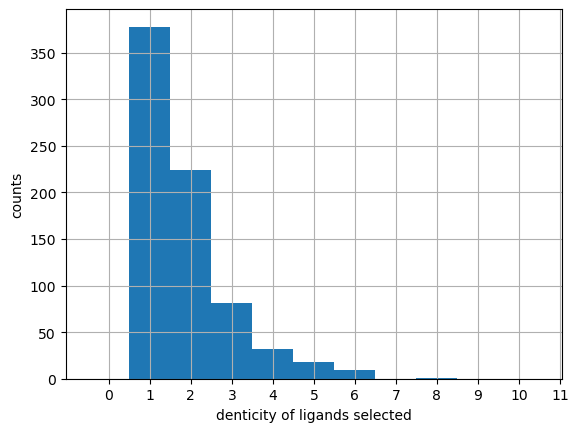

In [20]:
ax = outdf.denticity.hist(bins=np.arange(0,12,1),align='left')
ax.set_xlabel('denticity of ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(np.arange(0,12,1));

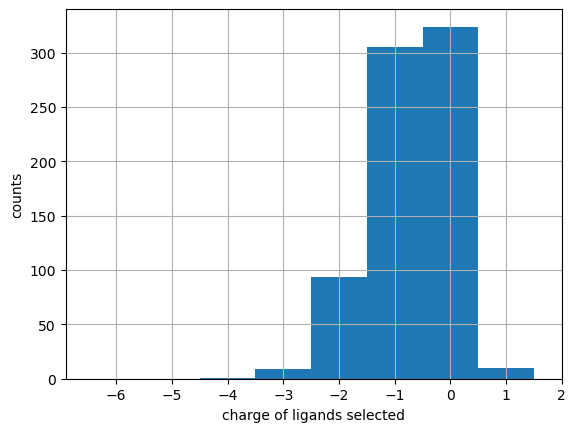

In [21]:
bins = np.arange(-6,3,1)
ax = outdf.charge.hist(bins=bins,align='left')
ax.set_xlabel('charge of ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(bins);

Text(0, 0.5, 'counts')

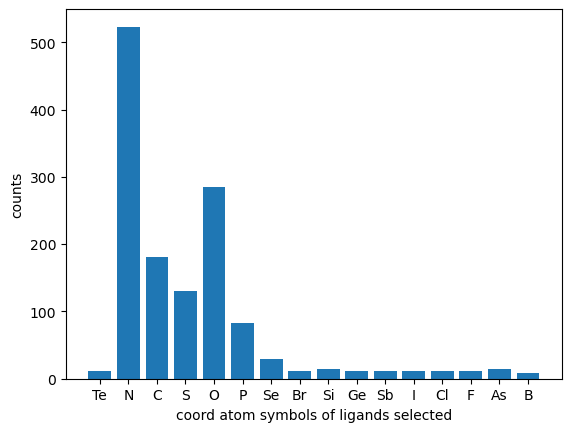

In [22]:
coord_atom_symbols = dict()
for i,row in outdf.iterrows():
    syms = row['coord_atom_symols'].split(',')
    vals,counts = np.unique(syms,return_counts=True)
    for j,val in enumerate(vals):
        coord_atom_symbols.update({val:coord_atom_symbols.get(val,0)+counts[j]})
syms = list(coord_atom_symbols.keys())
vals = list(coord_atom_symbols.values())
plt.bar(syms,vals)
plt.xlabel('coord atom symbols of ligands selected')
plt.ylabel('counts')

In [23]:
# Calculate number of atoms per-ligand
natoms = [] 
for i,row in tqdm(newoutdf.iterrows(),total=newoutdf.shape[0]):
    mol = convert_io_molecule(row['smiles']) # Including H
    natoms.append(len(mol.ase_atoms))
newoutdf['natoms'] = natoms

100%|██████████| 728/728 [01:27<00:00,  8.30it/s]


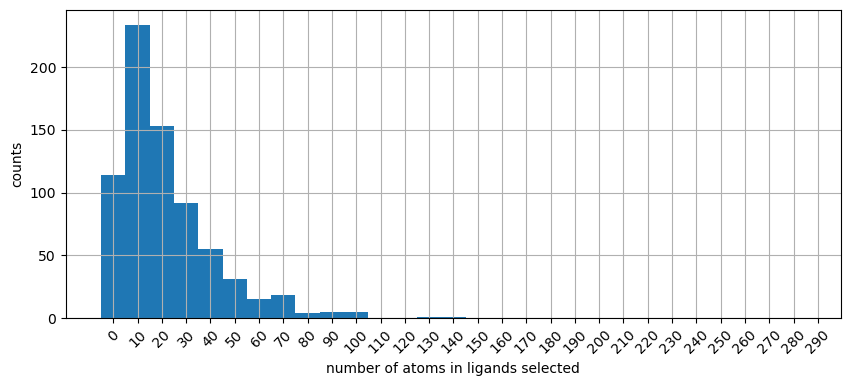

In [24]:
# Note - we should possibly down-select for number of atoms
bins = np.arange(0,300,10)
ax = newoutdf.natoms.hist(bins=bins,align='left',figsize=(10,4))
ax.set_xlabel('number of atoms in ligands selected')
ax.set_ylabel('counts')
ax.set_xticks(bins)
ax.set_xticklabels(bins,rotation=45);

In [25]:
newoutdf.to_pickle('v1_ligand_sampling_df.pkl')

In [92]:
# x = 0
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis,
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5,
#                 # labelatoms=True
#                 )

In [36]:
# x = 1
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis,labelinds=coordlists,w=300,h=300,columns=5)

In [35]:
# x = 2
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis,labelinds=coordlists,w=300,h=300,columns=5)

In [39]:
# x = 3
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis,labelinds=coordlists,w=300,h=300,columns=5)

In [99]:
# x = 4
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

# # Flag = 199

In [120]:
rem_inds = [199]

In [95]:
# x = 5
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [103]:
# x = 6
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 labels = np.arange((0+40*x),(40+40*x),1),
#                 # labelinds=coordlists,
#                 w=300,h=300,columns=5)

# #  Flag: 243, 247 -> Tri-iodine charges seem untrustworthy.

In [121]:
rem_inds += [243,247]

In [50]:
# x = 7
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [119]:
# x = 8
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)


# # Flag : 339 
# # FIX : 349 -> Should be [Cp-] ring.
# # Add more [Cp-] rings to ligand set.

In [122]:
rem_inds += [339,349]

In [56]:
# x = 9
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [60]:
# x = 10
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 labels = np.arange((0+40*x),(40+40*x),1),
#                 # labelinds=coordlists,
#                 w=300,h=300,columns=5)

# # Flag : 403 -> Incorrect smiles for [SO4]2-

In [123]:
rem_inds += [403]

In [109]:
# x = 11
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 labels = np.arange((0+40*x),(40+40*x),1),
#                 # labelinds=coordlists,
#                 w=300,h=300,columns=5)


# # Flag 452 is a duplicate of [SO4]2-
# # Is 446 a real chemical? - Evan/Daniel say yes.

In [124]:
rem_inds += [452]

In [112]:
# x = 12
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 labels = np.arange((0+40*x),(40+40*x),1),
#                 # labelinds=coordlists,
#                 w=300,h=300,columns=5)


# # Flag : 507 - is this real? Possibly, but making judgement call to remove from the list.

In [125]:
rem_inds += [507]

In [75]:
# x = 13
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [79]:
# x = 14
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

# # Flag 575/576 -
# #  575: charge=-3,bidentate 576: charge=-2, bidentate
# # Seems like only one of these would be reasonable? -> Picking charge=-2

In [126]:
rem_inds += [575]

In [81]:
# x = 15
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [83]:
# x = 16
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [85]:
# x = 17
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [87]:
# x = 18
# tdf = newoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=300,h=300,columns=5)

In [127]:
rem_inds

[199, 243, 247, 339, 349, 403, 452, 507, 575]

In [171]:
fixoutdf = newoutdf.drop(index=newoutdf.iloc[rem_inds].index.tolist())

In [172]:
fixoutdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency,selected_coord_type,selected_non_coord_type,natoms
634,[Te-]c1ccccc10,[Te-]c1ccccc1,[0],Te,Te,"C,C,C,C,C,C,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H",-1,1,"Cu,1",59,Te,None,12
141397,C[Si](C)(C)[Si]([Te-])([Si](C)(C)C)[Si](C)(C)C5,C[Si](C)(C)[Si]([Te-])([Si](C)(C)C)[Si](C)(C)C,[5],Te,Te,"C,Si,C,C,Si,Si,C,C,C,Si,C,C,C,H,H,H,H,H,H,H,H,...","C.3,Si,C.3,C.3,Si,Si,C.3,C.3,C.3,Si,C.3,C.3,C....",-1,1,"Mg,2",39,Te,None,41
43690,[Te-2]0,[Te-2],[0],Te,Te,,,-2,1,"V,5",13,Te,None,1
133891,"[Te-][Te][Te][Te-]0,3",[Te-][Te][Te][Te-],"[0, 3]","Te,Te","Te,Te","Te,Te","Te,Te",-2,2,"Mo,4",12,Te,None,4
2567,[Te](c1ccccc1)c1ccccc10,[Te](c1ccccc1)c1ccccc1,[0],Te,Te,"C,C,C,C,C,C,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C...",0,1,"Hg,2",11,Te,None,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138484,O=C([O-])c1ccc2OCOc2c12,O=C([O-])c1ccc2OCOc2c1,[2],O,O.co2,"O,C,C,C,C,C,O,C,O,C,C,H,H,H,H,H","O.co2,C.2,C.ar,C.ar,C.ar,C.ar,O.3,C.3,O.3,C.ar...",-1,1,"Cu,2",12,None,O.3,17
96885,OCNC(=O)c1cccnc19,OCNC(=O)c1cccnc1,[9],N,N.ar,"O,C,N,C,O,C,C,C,C,C,H,H,H,H,H,H,H,H","O.3,C.3,N.am,C.2,O.2,C.ar,C.ar,C.ar,C.ar,C.ar,...",0,1,"Cu,2",17,None,O.3,19
55560,"Oc1ccccc1C([O-])=NN=Cc1ccccn18,10,17",Oc1ccccc1C([O-])=NN=Cc1ccccn1,"[8, 10, 17]","O,N,N","O.co2,N.2,N.ar","O,C,C,C,C,C,C,C,N,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H","O.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.2,N.2,C.2,...",-1,3,"Cd,2",18,None,O.3,28
131345,CC1(C)OC(C(O1)C([O-])(c1ccccc1)c1ccccc1)C([O-]...,CC1(C)OC(C(O1)C([O-])(c1ccccc1)c1ccccc1)C([O-]...,"[8, 22]","O,O","O.co2,O.co2","C,C,C,O,C,C,O,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,O.3,C.3,C.3,O.3,C.3,C.ar,C.ar,C.ar...",-2,2,"Ti,4",13,None,O.3,63


In [173]:
# x = 8
# tdf = fixoutdf.iloc[(0+40*x):(40+40*x)]
# smis = tdf.smiles
# coordlists = []
# for i,row in tdf.iterrows():
#     coordlist = [None]*row['natoms']
#     for j in row['coordList']:
#         coordlist[j] = 1
#     coordlists.append(coordlist)
# view_structures(smis, 
#                 # labels = np.arange((0+40*x),(40+40*x),1),
#                 labelinds=coordlists,
#                 w=200,h=200,columns=5)

In [174]:
fixoutdf.reset_index(drop=True,inplace=True)
# Fix "denticity" of aromatic rings

In [175]:
fixoutdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency,selected_coord_type,selected_non_coord_type,natoms
0,[Te-]c1ccccc10,[Te-]c1ccccc1,[0],Te,Te,"C,C,C,C,C,C,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H",-1,1,"Cu,1",59,Te,None,12
1,C[Si](C)(C)[Si]([Te-])([Si](C)(C)C)[Si](C)(C)C5,C[Si](C)(C)[Si]([Te-])([Si](C)(C)C)[Si](C)(C)C,[5],Te,Te,"C,Si,C,C,Si,Si,C,C,C,Si,C,C,C,H,H,H,H,H,H,H,H,...","C.3,Si,C.3,C.3,Si,Si,C.3,C.3,C.3,Si,C.3,C.3,C....",-1,1,"Mg,2",39,Te,None,41
2,[Te-2]0,[Te-2],[0],Te,Te,,,-2,1,"V,5",13,Te,None,1
3,"[Te-][Te][Te][Te-]0,3",[Te-][Te][Te][Te-],"[0, 3]","Te,Te","Te,Te","Te,Te","Te,Te",-2,2,"Mo,4",12,Te,None,4
4,[Te](c1ccccc1)c1ccccc10,[Te](c1ccccc1)c1ccccc1,[0],Te,Te,"C,C,C,C,C,C,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C...",0,1,"Hg,2",11,Te,None,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,O=C([O-])c1ccc2OCOc2c12,O=C([O-])c1ccc2OCOc2c1,[2],O,O.co2,"O,C,C,C,C,C,O,C,O,C,C,H,H,H,H,H","O.co2,C.2,C.ar,C.ar,C.ar,C.ar,O.3,C.3,O.3,C.ar...",-1,1,"Cu,2",12,None,O.3,17
715,OCNC(=O)c1cccnc19,OCNC(=O)c1cccnc1,[9],N,N.ar,"O,C,N,C,O,C,C,C,C,C,H,H,H,H,H,H,H,H","O.3,C.3,N.am,C.2,O.2,C.ar,C.ar,C.ar,C.ar,C.ar,...",0,1,"Cu,2",17,None,O.3,19
716,"Oc1ccccc1C([O-])=NN=Cc1ccccn18,10,17",Oc1ccccc1C([O-])=NN=Cc1ccccn1,"[8, 10, 17]","O,N,N","O.co2,N.2,N.ar","O,C,C,C,C,C,C,C,N,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H","O.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.2,N.2,C.2,...",-1,3,"Cd,2",18,None,O.3,28
717,CC1(C)OC(C(O1)C([O-])(c1ccccc1)c1ccccc1)C([O-]...,CC1(C)OC(C(O1)C([O-])(c1ccccc1)c1ccccc1)C([O-]...,"[8, 22]","O,O","O.co2,O.co2","C,C,C,O,C,C,O,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,O.3,C.3,C.3,O.3,C.3,C.ar,C.ar,C.ar...",-2,2,"Ti,4",13,None,O.3,63


In [176]:
from architector.io_ptable import ligands_dict

In [177]:
view_structures(ligands_dict['cp']['smiles'],labelinds=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [178]:
from architector import convert_io_molecule,view_structures,build_complex
from architector.io_obabel import functionalize,get_obmol_smiles,get_smiles_obmol
import copy

In [179]:
cp_lig = ligands_dict['cp']
view_structures(cp_lig['smiles'],labelinds=True)
tobmol = get_obmol_smiles(cp_lig['smiles'],addHydrogens=False)
outmol = functionalize(tobmol,
                       functional_group='C',
                       smiles_inds=[0,1,2,3,4])
newsmi = get_smiles_obmol(outmol)
view_structures(newsmi,labelinds=True)
methyl_cp = copy.deepcopy(cp_lig)
methyl_cp['smiles'] = newsmi

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [180]:
cp_lig = ligands_dict['cp']
view_structures(cp_lig['smiles'], 
                labelinds=True)
tobmol = get_obmol_smiles(cp_lig['smiles'], 
                          addHydrogens=False)
outmol = functionalize(tobmol,
                       functional_group='C(C)(C)C',
                       smiles_inds=[1,2,4])
newsmi = get_smiles_obmol(outmol)
view_structures(newsmi, 
                labelinds=True)
bulky_cp = copy.deepcopy(cp_lig)
bulky_cp['smiles'] = newsmi

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [181]:
fixoutdf.iloc[3]

uid                        [Te-][Te][Te][Te-]0,3
smiles                        [Te-][Te][Te][Te-]
coordList                                 [0, 3]
coord_atom_symols                          Te,Te
coord_atom_types                           Te,Te
non_coord_atom_symbols                     Te,Te
non_coord_atom_types                       Te,Te
charge                                        -2
denticity                                      2
metal_ox_bound                              Mo,4
frequency                                     12
selected_coord_type                           Te
selected_non_coord_type                     None
natoms                                         4
Name: 3, dtype: object

In [183]:
for lig in [cp_lig,bulky_cp,methyl_cp]:
    tdict = {}
    n = fixoutdf.shape[0]
    tdict['uid'] = lig['smiles'] + ','.join([str(x) for x in lig['coordList']])
    tdict['smiles'] = lig['smiles']
    tdict['coordList'] = lig['coordList']
    tmol = convert_io_molecule(tdict['smiles'])
    tdict['coord_atom_symols'] = ','.join([x for i,x in enumerate(mol.ase_atoms.get_chemical_symbols()) if i in tdict['coordList']])
    tdict['coord_atom_types'] = ','.join([x for i,x in enumerate(mol.atom_types) if i in tdict['coordList']])
    tdict['non_coord_atom_symbols'] = ','.join([x for i,x in enumerate(mol.ase_atoms.get_chemical_symbols()) if i not in tdict['coordList']])
    tdict['non_coord_atom_types'] = ','.join([x for i,x in enumerate(mol.atom_types) if i not in tdict['coordList']])
    tdict['charge'] = -1
    tdict['denticity'] = 3 # Note that Cp ligands take the place of tridentate meridonial ligands (hence, tridentate)
    tdict['metal_ox_bound'] = 'Many'
    tdict['frequency'] = 100
    tdict['selected_coord_type'] = 'C.ar'
    tdict['selected_non_coord_type'] = None
    tdict['natoms'] = len(mol.atom_types)
    fixoutdf.loc[n] = tdict

In [184]:
fixoutdf

,uid,smiles,coordList,coord_atom_symols,coord_atom_types,non_coord_atom_symbols,non_coord_atom_types,charge,denticity,metal_ox_bound,frequency,selected_coord_type,selected_non_coord_type,natoms
0,[Te-]c1ccccc10,[Te-]c1ccccc1,[0],Te,Te,"C,C,C,C,C,C,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,H,H,H,H,H",-1,1,"Cu,1",59,Te,None,12
1,C[Si](C)(C)[Si]([Te-])([Si](C)(C)C)[Si](C)(C)C5,C[Si](C)(C)[Si]([Te-])([Si](C)(C)C)[Si](C)(C)C,[5],Te,Te,"C,Si,C,C,Si,Si,C,C,C,Si,C,C,C,H,H,H,H,H,H,H,H,...","C.3,Si,C.3,C.3,Si,Si,C.3,C.3,C.3,Si,C.3,C.3,C....",-1,1,"Mg,2",39,Te,None,41
2,[Te-2]0,[Te-2],[0],Te,Te,,,-2,1,"V,5",13,Te,None,1
3,"[Te-][Te][Te][Te-]0,3",[Te-][Te][Te][Te-],"[0, 3]","Te,Te","Te,Te","Te,Te","Te,Te",-2,2,"Mo,4",12,Te,None,4
4,[Te](c1ccccc1)c1ccccc10,[Te](c1ccccc1)c1ccccc1,[0],Te,Te,"C,C,C,C,C,C,C,C,C,C,C,C,H,H,H,H,H,H,H,H,H,H","C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C...",0,1,"Hg,2",11,Te,None,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,CC1(C)OC(C(O1)C([O-])(c1ccccc1)c1ccccc1)C([O-]...,CC1(C)OC(C(O1)C([O-])(c1ccccc1)c1ccccc1)C([O-]...,"[8, 22]","O,O","O.co2,O.co2","C,C,C,O,C,C,O,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,...","C.3,C.3,C.3,O.3,C.3,C.3,O.3,C.3,C.ar,C.ar,C.ar...",-2,2,"Ti,4",13,None,O.3,63
718,"OCc1ccnc(c1)c1cc(CO)ccn15,15",OCc1ccnc(c1)c1cc(CO)ccn1,"[5, 15]","N,N","N.ar,N.ar","O,C,C,C,C,C,C,C,C,C,C,O,C,C,H,H,H,H,H,H,H,H,H,...","O.3,C.3,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.a...",0,2,"Ru,3",21,None,O.3,28
719,"C1=C[CH-]C=C10,1,2,3,4",C1=C[CH-]C=C1,"[0, 1, 2, 3, 4]","O,C,C,C,C","O.3,C.3,C.ar,C.ar,C.ar","N,C,C,C,C,C,C,O,C,C,N,H,H,H,H,H,H,H,H,H,H,H,H","N.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.3,O.3,C.ar,C.a...",-1,3,Many,100,C.ar,None,28
720,"c1c([c-](cc1C(C)(C)C)C(C)(C)C)C(C)(C)C0,1,2,3,4",c1c([c-](cc1C(C)(C)C)C(C)(C)C)C(C)(C)C,"[0, 1, 2, 3, 4]","O,C,C,C,C","O.3,C.3,C.ar,C.ar,C.ar","N,C,C,C,C,C,C,O,C,C,N,H,H,H,H,H,H,H,H,H,H,H,H","N.ar,C.ar,C.ar,C.ar,C.ar,C.ar,C.3,O.3,C.ar,C.a...",-1,3,Many,100,C.ar,None,28


In [186]:
x = 8
tdf = fixoutdf.iloc[(0+40*x):(40+40*x)]
smis = tdf.smiles
coordlists = []
for i,row in tdf.iterrows():
    coordlist = [None]*row['natoms']
    for j in row['coordList']:
        coordlist[j] = 1
    coordlists.append(coordlist)
view_structures(smis, 
                labels = np.arange((0+40*x),(40+40*x),1),
                # labelinds=coordlists,
                w=200,h=200,columns=5)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [187]:
fixinds_dents = [341,342,343,344,345]
# Note that pi-bound planar ligands take the place of tridentate meridonial ligands (hence, tridentate)
fixoutdf.loc[fixinds_dents,'denticity'] = 3

In [190]:
fixoutdf.to_pickle('fixed_full_ligand_sample.pkl')